# Observation captioning

Let's try to learn to generate the sentence corresponding to a given observation.

The Observation Encoder will be trained to encode the observation, and the Decoder will have to predict the sentence description of the observation.

Load observation-sentence pairs.

In [1]:
import json

def load_pairs(data_path):
    with open(data_path, "r") as f:
        data = json.load(f)
    pairs = []
    for step, s_data in data.items():
        if not step.startswith("Step"):
            continue
        pairs.append({
            "observation": s_data["Agent_0"]["Observation"],
            "sentence": s_data["Agent_0"]["Sentence"][1:-1]
        })
        pairs.append({
            "observation": s_data["Agent_1"]["Observation"],
            "sentence": s_data["Agent_1"]["Sentence"][1:-1]
        })
    return pairs

data_pairs = load_pairs("test_data/Sentences_Generated_P1.json")
data_pairs[0]

{'observation': [0.3566717617981794,
  0.22018956073987805,
  0.0,
  0.0,
  0.0,
  1.0,
  1.0,
  0.0,
  0.0,
  0.0,
  1.0,
  1.0,
  0.0,
  0.0,
  1.0,
  -0.4988445287954038,
  -0.25249793046375035],
 'sentence': ['Located', 'East', 'Landmark', 'South', 'West']}

Split data

In [2]:
train_data = data_pairs[:80000]
test_data = data_pairs[80000:]

Initialise the models

In [5]:
import torch
from model.modules.lm import GRUDecoder, OneHotEncoder
from model.modules.obs import ObservationEncoder

word_encoder = OneHotEncoder(
    ['South','Not','Located','West','Object','Landmark','North','Center','East'])

dec = GRUDecoder(32, word_encoder)

obs_enc = ObservationEncoder(17, 32)

Initialise loss and optimizer

In [6]:
from torch import nn, optim

criterion = nn.NLLLoss()
optim = optim.Adam(list(dec.parameters()) + list(obs_enc.parameters()), lr=0.01)

Train

In [7]:
import time
import random
import numpy as np
from tqdm import tqdm 

def train(data, obs_enc, dec, word_encoder, criterion, optim, n_iters=10000, batch_size=64):
    start = time.time()
    
    plot_losses = []
    
    for s_i in tqdm(range(n_iters)):
        optim.zero_grad()
        
        loss = 0
        
        # Sample batch
        batch = random.sample(data, batch_size)
        obs_batch = []
        sent_batch = []
        for pair in batch:
            obs_batch.append(pair["observation"])
            sent_batch.append(pair["sentence"])
        
        # Encode observations
        obs_tensor = torch.Tensor(np.array(obs_batch))
        context_batch = obs_enc(obs_tensor)
        
        # Decoder forward pass
        encoded_targets = word_encoder.encode_batch(sent_batch)
        decoder_outputs, _ = dec(context_batch, encoded_targets)
        
        # Compute loss
        for d_o, e_t in zip(decoder_outputs, encoded_targets):
            e_t = torch.argmax(e_t, dim=1)
            loss += criterion(d_o, e_t)
        
        # Backprop
        loss.backward()
        optim.step()
        
        plot_losses.append(loss.item() / batch_size)
    
    return plot_losses
            
plot_loss = train(data_pairs, obs_enc, dec, word_encoder, criterion, optim)

100%|██████████████████████████████████████████████████████████████| 10000/10000 [23:21<00:00,  7.13it/s]


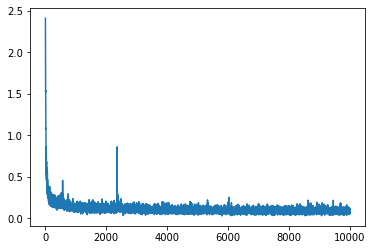

In [8]:
import matplotlib.pyplot as plt

plt.plot(plot_loss)

In [10]:
s = test_data[9]
s_enc = obs_enc(torch.Tensor([s["observation"]]))
_, s_pred = dec(s_enc)
print(s)
word_encoder.decode_batch(s_pred)

{'observation': [-0.46253025652321633, -0.4361228108850216, -0.052370193572788354, -0.12048694108156249, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.46431834132394434, 0.8647810600646555], 'sentence': ['Located', 'South', 'West', 'Landmark', 'North', 'East']}


[['Located', 'South', 'West', 'Landmark', 'North', 'East']]